# Wikimedia Data Challenge
-------------------------------------------------------
## Contents:
--------------

__[1. Introduction](#first-bullet)__

__[2. Data Analysis](#second-bullet)__

__[3.What The Average Daily Clickthrough Rates?](#third-bullet)__

__[4. Which Results Do Clients Click First?](#fourth-bullet)__

__[5. What Are The Daily Average Zero Results Rate?](#fifth-bullet)__

__[6. What Factors Affect User Session Length?](#sixth-bullet)__

__[7. Conclusion](#seventh-bullet)__


The source code can be found <a href="https://github.com/mdh266/Wikimedia_Challenge">here</a>.

-------------------------------------------------------

## Introduction <a class="anchor" id="first-bullet"></a>
-------------------------------------------------------
This Project was put out as data challenge by the <a href="https://wikimediafoundation.org/wiki/Home">Wikimedia Foundation</a> for a data analyst position. I thought it would be a great opportunity to brush up on some data analysis tools in Pandas and decided to complete the challenge.


The goal of the project was to analyze data from *event logging* (EL) to track a variety of performance and usage metrics to help the company make decisions. Specifically, they were interested in:

- *clickthrough rate*: the proportion of search sessions where the user clicked on one of the results displayed

- *zero results rate*: the proportion of searches that yielded 0 results

EL uses JavaScript to asynchronously send messages (events) to their servers when the user has performed specific actions. 

-------------------------------------------------------
### Data  <a class="anchor" id="second-bullet"></a>
-------------------------------------------------------
The dataset comes from a [tracking schema](3) that the Wikimedia Foundation uses for assessing user satisfaction. Desktop users are randomly sampled to be anonymously tracked by this schema which uses a "I'm alive" pinging system that we can use to estimate how long our users stay on the pages they visit. The dataset contains just a little more than a week of EL data.


| Column          | Value   | Description                                                                       |
|:----------------|:--------|:----------------------------------------------------------------------------------|
| uuid            | string  | Universally unique identifier (UUID) for backend event handling.                  |
| timestamp       | integer | The date and time (UTC) of the event, formatted as YYYYMMDDhhmmss.                |
| session_id      | string  | A unique ID identifying individual sessions.                                      |
| group           | string  | A label ("a" or "b").                                     |
| action          | string  | Identifies in which the event was created. See below.                             |
| checkin         | integer | How many seconds the page has been open for.                                      |
| page_id         | string  | A unique identifier for correlating page visits and check-ins.                    |
| n_results       | integer | Number of hits returned to the user. Only shown for searchResultPage events.      |
| result_position | integer | The position of the visited page's link on the search engine results page (SERP). |

The following are possible values for an event's action field:

- **searchResultPage**: when a new search is performed and the user is shown a SERP.
- **visitPage**: when the user clicks a link in the results.
- **checkin**: when the user has remained on the page for a pre-specified amount of time.

-------------------------------------------------------
### Objectives
-------------------------------------------------------

The objectives of this project are to find answers to the following questions:

1. What is their daily overall clickthrough rate? How does it vary between the groups?

2. Which results do people tend to try first? How does it change day-to-day?

3. What is their daily overall zero results rate? How does it vary between the groups?

4. Let *session length* be approximately the time between the first event and the last event in a session. Choose a variable from the dataset and describe its relationship to session length. Visualize the relationship.



We'll dive in to the analysis below, but first well read in some basic libraries as well as some functions which we will use.  The functions were defined outside this notebook can found on the <a href="https://github.com/mdh266/Wikimedia_Challenge">GitHub repo</a>.

In [1]:
import pandas as pd
import numpy as np
import os.path
import pandas as pd
from itertools import chain
import matplotlib.pyplot as plt
from plotting_functions import (plot_grouped_and_ungrouped,
                                plot_daily_clicked,
                                plot_session_length_by_group,
                                plot_session_length_by_group_percentages)

from helper_functions import (searched_per_day_by_group,
                              searched_per_day,
                              average_click_through_rate,
                              average_click_through_rate_by_group,
                              average_zero_rate,
                              average_zero_rate_by_group,
                              get_sessions_with_n_results)
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

def read_in_data():
    """
    This function does the following,
    
    1.) Reads in the csv file:
    
        'events_logs.csv'
    
    and set the index to be the timestamp and print its to a
    new file called:
        
        'new_events_log.csv'
        
    2.) Then it just reads in'new_events_log.csv' and returns the
    corresponding dataframe.
    
    If the file 'new_events_log.csv' already exists then only 2.) 
    is done.
    
    :return: Dataframe of the data.
    
    :rvalue: Pandas DataFrame.
    
    """
    # 1.
    if os.path.isfile('new_events_log.csv') is False:
        df = pd.read_csv("events_log.csv")
        df['timestamp'] = df['timestamp'].astype(int)
        df.to_csv('new_events_log.csv')
    
    #2.) 
    df = pd.read_csv("new_events_log.csv",
                     parse_dates=['timestamp'], 
                     index_col='timestamp')
    
    # drop some extra column
    df = df.drop('Unnamed: 0',axis=1)
    
    return df

-------------------------------------------------------
## Data Analysis <a class="anchor" id="second-bullet"></a>
-------------------------------------------------------
The data was provided in csv format in a file called, "events_log.csv." When reading in the data I wanted to set the index of the dataframe to be a TimeStamp.  This can be achieved using the pandas command:

    df = pd.read_csv("events_log.csv",
                     parse_dates=['timestamp'], 
                     index_col='timestamp')
                  
                  
However, this would not work because the TimeStamp was being read in as an float in scientific notation and therefore wouldnt convert to DateTime properly. I was able to circumvent this by first reading in the dataframe as usual, then 
changing the timestamp variable to an integer with the command:
    
    df = pd.read_csv('events_log.csv')
    df['timestamp'] = df['timestamp'].astype(int)

I then wrote the dataframe to csv as "new_events_log.csv" and read it in again using the previous technique.  I wanted my code to work even if the person had download the original csv and not the new one.  So,  I wrote a function that did the above if "new_events_log.csv" doesn't exist, and if it did exist just read it in.   This is the funciton called below,

In [3]:
df = read_in_data()

I included this function specifically in this notebook since it run much faster when it was defined within the notebook then as an outside function.

Now, we can get a basic look at our data by using the <code>info()</code> function:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 400165 entries, 2016-03-01 10:38:42 to 2016-03-04 14:43:03
Data columns (total 8 columns):
uuid               400165 non-null object
session_id         400165 non-null object
group              400165 non-null object
action             400165 non-null object
checkin            223824 non-null float64
page_id            400165 non-null object
n_results          136234 non-null float64
result_position    230482 non-null float64
dtypes: float64(3), object(5)
memory usage: 27.5+ MB


Let's get an idea of the number of sessions this takes into account for,

In [5]:
session_ids = df.session_id.unique()
print("Number of sessions: {}".format(len(session_ids)))

Number of sessions: 68028


If we sort the dataframe by <code>session_id</code>, we can see how long each person stayed on a webpage,

In [7]:
df.sort_values('session_id')\
  .head()\
  .sort_index()

,uuid,session_id,group,action,checkin,page_id,n_results,result_position
timestamp,,,,,,,,
2016-03-03 15:20:45,e6f9280c8df5536490eb925a91979a3b,0000cbcb67c19c45,b,searchResultPage,NaN,fdeeb9aaf0130d41,20.0,NaN
2016-03-07 08:49:55,5b394c862bf657d98bcd25589a5247ac,0001382e027b2ea4,b,searchResultPage,NaN,7aa28c36c03380a0,18.0,NaN
2016-03-07 08:50:18,f01620582b615c03812cb1af2e804102,0001382e027b2ea4,b,checkin,20.0,f88793c95e778898,NaN,1.0
2016-03-07 08:51:28,fa6a1974487154aa95ddb93d8d5d3734,0001382e027b2ea4,b,checkin,90.0,f88793c95e778898,NaN,1.0
2016-03-07 08:53:28,70d367a1c60156c1b1723d1e4196a987,0001382e027b2ea4,b,checkin,210.0,f88793c95e778898,NaN,1.0


I dug deeper into looking at the data on my own, but won't show it because it's superfluous.  Instead, let's get into analyzing the data.  Instead lets get to answering the questions posed in the challenge.

### What The Average Daily Clickthrough Rates? <a class="anchor" id="third-bullet"></a>

We first set out to understand what the average daily clickthrough rate of the users is, we can do this by first finding out how many people visit the website per day. 
In order to find this number on a per day basis, we have to first perform a <a href="http://pandas.pydata.org/pandas-docs/stable/groupby.html">groupby</a> day,

    df.groupby([pd.TimeGrouper('D')])
    
and then count the number of rows where a search was performed, i.e. when each rows has,

    'action' = 'searchResultPage'

We then need the number of people that visited a search result page on a daily basis.  We repeat the same groupby call, but now count the number of records where the corresponding rows have, 

    'action' == 'visitPage'

We then take the two values for each day, divide them and take the average to get the average daily clickthrough rate.  This is what is completed in the function call, 

In [8]:
rate = average_click_through_rate(df)

We also have to answer the same question on clickthrough rate, but this time taking into account the differences between 'group a' and 'group b'.  This can be achieved using the same procedure as before, but we group by day as well as the session 'group', i.e.

    df.groupby([pd.TimeGrouper('D'),'group'])

We then count the number of rows that have the different actions discussed previously.  This procedure is exactly what is done in the function, 

    average_click_through_rate_by_group(...) 
    
The results of the grouped and ungrouped results are shown below:

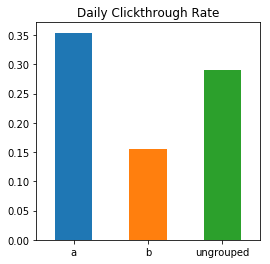

In [9]:
diff = average_click_through_rate_by_group(df)

plot_grouped_and_ungrouped(diff, 
                           rate, 
                           "Daily Clickthrough Rate")

We can see that the clickthrough rate of 'group a' is almost twice that of 'group b'.

-------------------------------------------------------
### Which Results Do Clients Click First? <a class="anchor" id="fourth-bullet"></a>
-------------------------------------------------------
In order to figure out which links clients click first we have get the number of search result pages that were clicked on and group by day, <code>session_id</code> and <code>result_positon</code>.  We do this using the <a href="http://pandas.pydata.org/pandas-docs/stable/groupby.html">groupby</a> Pandas call as well as filtering the rows by which rows includes a webpage that has been visited.  We can tell which page has been visited by getting the <code>result_position</code> of the page that was visisted. The groupby and filter call are below,

In [10]:
clicked = df.groupby([pd.TimeGrouper('D'),'session_id','result_position'])\
            .apply(lambda row: len(row[row['result_position'] > 0]))

In [11]:
clicked.head()

timestamp   session_id        result_position
2016-03-01  001e2d0e159172d2  2.0                2
            0024c4506bf92e1c  1.0                9
            0029420a5f8c7d90  1.0                1
            002b97995ca9ce77  3.0                2
                              18.0               2
dtype: int64

We note that the values in the series is the number of times that the <code>result_positon </code>appeared in the rows of the dataframe. We see that in session, <code>002b97995ca9ce77</code>, the user went to both the 3rd listed result and the 18th listed result. Let's take a look at the data for that session in chronological order:

In [12]:
df[df.session_id == '002b97995ca9ce77'].sort_index()

,uuid,session_id,group,action,checkin,page_id,n_results,result_position
timestamp,,,,,,,,
2016-03-01 06:56:58,8e154e03862750dca50374c05170fd0b,002b97995ca9ce77,a,searchResultPage,NaN,b9aef1d46f18a05c,20.0,NaN
2016-03-01 06:57:10,df81855edb66504e9ab1a3b3c8579c33,002b97995ca9ce77,a,visitPage,NaN,ed9547024a71f9f2,NaN,3.0
2016-03-01 06:57:20,afe45772a9c55a54a4dcd36f8e70faf3,002b97995ca9ce77,a,checkin,10.0,ed9547024a71f9f2,NaN,3.0
2016-03-01 06:57:25,62b963cbaca55a7fbd4c712832f19d36,002b97995ca9ce77,a,searchResultPage,NaN,374343e8ba419730,1.0,NaN
2016-03-01 06:57:30,6e9ae9a14484502596983c5ec9c9914d,002b97995ca9ce77,a,searchResultPage,NaN,60fda08472a6f1c5,20.0,NaN
2016-03-01 06:58:19,4c0f8453754257079692d2a55b4fe232,002b97995ca9ce77,a,visitPage,NaN,e59ec99472571d5c,NaN,18.0
2016-03-01 06:58:29,51b31a5a14855e1cbef3847a88fc1fb7,002b97995ca9ce77,a,checkin,10.0,e59ec99472571d5c,NaN,18.0


We can see that the person first checked out the 3rd result and then went back to the search results page and clicked on the 18th page.  We have to be careful that we only take the first result webpage the user clicked on in the analysis.  I did this by first filtering the dataframe to only included rows where the person was checkedin and then sorted by the <code>TimeStamp</code> (index):

In [13]:
visited_pages = df[df.action == 'visitPage'].sort_index()

Next we groupby the day and <code>session_id</code> and take the first result in the column corresponding to the <code>result_position</code> column.  Since the dataframe is sorted in chronological order we can assume that the result we get back is the first search result that the user clicked on:

In [14]:
first_clicked = visited_pages.groupby([pd.TimeGrouper('D'),'session_id',], sort=True)['result_position']\
                             .first()

We print out the first few reults to see what they like:

In [15]:
first_clicked.head()

timestamp   session_id      
2016-03-01  001e2d0e159172d2    2.0
            0024c4506bf92e1c    1.0
            0029420a5f8c7d90    1.0
            002b97995ca9ce77    3.0
            003037c8d3c3fe94    2.0
Name: result_position, dtype: float64

As a sanity check we can see that the value for <code>session_id</code>, <code>002b97995ca9ce77</code>, is 3 which is what we expected.  


Now we loop over the number of days and count the  <code>result_position</code>s of the pages that were first visited and order them by <code>result_position</code>.  We plot the daily results as bar graphs, taking the top 20 most clicked <code>result_position</code>s below:

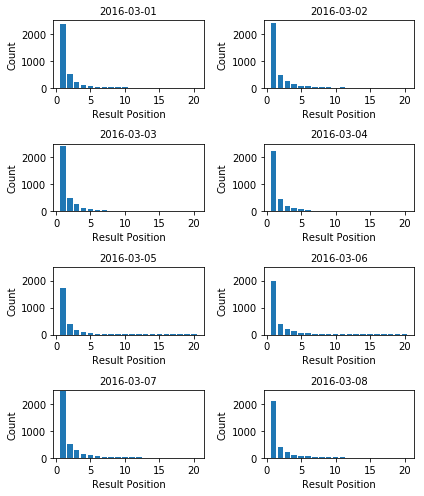

In [16]:
plot_daily_clicked(first_clicked, 20)

The first thing we see is that the most frequently clicked is the first result listed and the number of click on the rest of the results drop exponentially with the rank of the listing. This makes sense as hopefully the first returned result is the most relevant. 

Another interesting thing to note is the number of clicks changes throughout the week.  The number of clicks on the first result seem to be around 2400-2500 for the first three days. On the fourth day they drop to 2300, then drop down to 1700 on the fifth day before recovering to 2000 on the 6th. The clickthrough rate of the first results returns to the 2400-2500 range on the seventh day and finally drops again to around 2200 on the eigth day. We can see that most days the first search results get about 2200-2500 clicks, but a noticable drop in click rate for the first search result occurs on the 5th day.  We can also see the same pattern occurs for the click rate on the second search result.

-------------------------------------------------------
### What Are The Daily Average Zero Results Rate? <a class="anchor" id="fifth-bullet"></a>
-------------------------------------------------------

Now we are interested in the daily zero rates, that is the the number of searches that return zero results. We group the data by day as we did in Question 1. and then count the number of rows that have,

    'n_results' == 0
    
and divide by the number of searches. This gives us the the zero rate for each day and is the done in the function:

In [17]:
zero_rate = average_zero_rate(df)

We now repeat the same process as above, but also group by the 'group', that is whether the session is in 'group a' or in 'group b'. This is done in the function,

    average_zero_rate_by_group(...)
    
and we plot the results below,

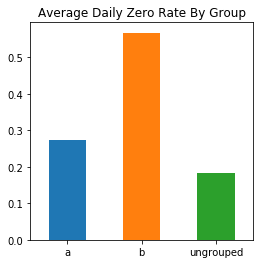

In [18]:
diff2 = average_zero_rate_by_group(df)
plot_grouped_and_ungrouped(diff2, 
                           zero_rate, 
                           'Average Daily Zero Rate By Group')

We can see that the average zero rate is much higher in group b than group a, its almost twice the rate in group a.  This makes sense, since group b has a smaller clickthrough rate and having zero search results would definitely result in less clickthroughs.

-------------------------------------------------------
### What Factors Affect User Session Length? <a class="anchor" id="sixth-bullet"></a>
-------------------------------------------------------
Now we want to look into the session length and what factors may affect it.

We first get the start time of each session by grouping by <code>session_id</code> and taking the first row.  We have to use the command, <code>nth(0)</code> instead of <code>first()</code>, because of issues with <code>first()</code> dropping cases that have <code>NaN</code> as values.  We drop the <code>uuid</code> column since it seems like useless information and pushes the dataframe off the screen when I print it.  The last thing I will mention is that we use <code>as_index = False</code> in the <code>groupby(...)</code> call so that we get keep the original index and a Pandas DataFrame is returned instead of Pandas Series:

In [21]:
session_begin = df.sort_index()\
                  .groupby(['session_id'], sort=True, as_index=False)\
                  .nth(0)\
                  .drop('uuid',axis=1)

session_begin.sort_values('session_id')\
             .head()

,session_id,group,action,checkin,page_id,n_results,result_position
timestamp,,,,,,,
2016-03-03 15:20:45,0000cbcb67c19c45,b,searchResultPage,NaN,fdeeb9aaf0130d41,20.0,NaN
2016-03-07 08:49:55,0001382e027b2ea4,b,searchResultPage,NaN,7aa28c36c03380a0,18.0,NaN
2016-03-05 09:24:15,0001e8bb90445cb2,b,searchResultPage,NaN,6b7f8832f5b6cc7d,20.0,NaN
2016-03-08 16:19:46,000216cf18ae1ab1,a,searchResultPage,NaN,08cebdafafbe069a,20.0,NaN
2016-03-08 05:33:00,000527f711d50dfc,b,searchResultPage,NaN,41a14a053b06af6c,1.0,NaN


Now, I'm going to do a sanity check by looing at the session <code>0001382e027b2ea4</code> and making sure that the first TimeStamp is the same as the one above.

In [22]:
test_session = df[df.session_id == '0001382e027b2ea4'].sort_index()\
                                                      .drop('uuid',axis=1)
test_session.head()

,session_id,group,action,checkin,page_id,n_results,result_position
timestamp,,,,,,,
2016-03-07 08:49:55,0001382e027b2ea4,b,searchResultPage,NaN,7aa28c36c03380a0,18.0,NaN
2016-03-07 08:49:58,0001382e027b2ea4,b,visitPage,NaN,f88793c95e778898,NaN,1.0
2016-03-07 08:50:08,0001382e027b2ea4,b,checkin,10.0,f88793c95e778898,NaN,1.0
2016-03-07 08:50:18,0001382e027b2ea4,b,checkin,20.0,f88793c95e778898,NaN,1.0
2016-03-07 08:50:28,0001382e027b2ea4,b,checkin,30.0,f88793c95e778898,NaN,1.0


Our simple test was a success!


In order to get the correct answer for the last TimeStamp of each session, I had to drop the <code>page_id</code> column, I'm not 100% confident as to why this was necessary, but I think it has to do with the issues of <code>NaNs</code>.

In [23]:
df2 = df.drop(['uuid','page_id'], axis=1)\
        .sort_index()

Now we do the same thing as previous for <code>session_begin</code>, but add take the <code>nth(-1)</code> instead of using <code>last()</code> because of issues with <code>last()</code> dropping cases with <code>NaNs</code>.

In [24]:
session_end = df2.groupby(['session_id'], sort=True,as_index=False)\
                .nth(-1)
    
session_end.sort_values('session_id')\
           .head()

,session_id,group,action,checkin,n_results,result_position
timestamp,,,,,,
2016-03-03 15:20:45,0000cbcb67c19c45,b,searchResultPage,NaN,20.0,NaN
2016-03-07 08:54:58,0001382e027b2ea4,b,checkin,300.0,NaN,1.0
2016-03-05 09:31:30,0001e8bb90445cb2,b,checkin,420.0,NaN,1.0
2016-03-08 16:20:44,000216cf18ae1ab1,a,searchResultPage,NaN,20.0,NaN
2016-03-08 05:33:00,000527f711d50dfc,b,searchResultPage,NaN,1.0,NaN


Now we perfrom another sanity check to make sure that the timestamp above for <code>session_id=0001382e027b2ea4</code> is the same as the last timestamp in the <code>test_session</code>:

In [25]:
test_session.tail()

,session_id,group,action,checkin,page_id,n_results,result_position
timestamp,,,,,,,
2016-03-07 08:52:28,0001382e027b2ea4,b,checkin,150.0,f88793c95e778898,NaN,1.0
2016-03-07 08:52:58,0001382e027b2ea4,b,checkin,180.0,f88793c95e778898,NaN,1.0
2016-03-07 08:53:28,0001382e027b2ea4,b,checkin,210.0,f88793c95e778898,NaN,1.0
2016-03-07 08:53:58,0001382e027b2ea4,b,checkin,240.0,f88793c95e778898,NaN,1.0
2016-03-07 08:54:58,0001382e027b2ea4,b,checkin,300.0,f88793c95e778898,NaN,1.0


It worked!  

So, now lets get the the start time of each session by creating a new column in the <code>session_begin</code> that strips the time from the index of the old dataframe, but we want to convert the Pandas TimeStamp objects into Python <a href="https://docs.python.org/2/library/datetime.html">DateTime</a> objects. We use the <a href="http://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_datetime.html">to_pydatetime()</a> to do this:

In [26]:
session_begin['time'] = session_begin.index.to_pydatetime()

Now we drop the TimeStamp as the index and drop the <code>checkin</code> column since that will be irrellevant and depends on the action.

In [27]:
session_begin = session_begin.reset_index()\
                             .drop(['timestamp','checkin'],axis=1)

Let's repeat the same process, but for <code>session_end</code>:

In [28]:
session_end['time'] = session_end.index.to_pydatetime()

session_end = session_end.reset_index()\
                         .drop(['timestamp','checkin'], axis=1)

Now we can <a href="http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html">
merge</a> the two pandas dataframes into one:

In [29]:
df3 = pd.merge(session_begin, 
               session_end, 
               on='session_id',
               suffixes=('_start','_end'))
df3.head()

,session_id,group_start,action_start,page_id,n_results_start,result_position_start,time_start,group_end,action_end,n_results_end,result_position_end,time_end
0,cbba9a98ba7b20cc,a,checkin,f79f531304a265f8,NaN,4.0,2016-03-01 00:00:01,a,searchResultPage,20.0,NaN,2016-03-01 00:00:17
1,c1f0f8499c6655cd,b,checkin,88bebe600b777ea9,NaN,NaN,2016-03-01 00:00:02,b,checkin,NaN,NaN,2016-03-01 00:00:12
2,614eaa17120fe46b,b,checkin,756d326815bc60c9,NaN,1.0,2016-03-01 00:00:02,b,checkin,NaN,1.0,2016-03-01 00:01:22
3,32edcb654a1dee57,b,checkin,d6122cfa99f1809f,NaN,1.0,2016-03-01 00:00:05,b,checkin,NaN,1.0,2016-03-01 00:04:38
4,34ba1f4ed8fa8368,b,checkin,b7502d32b09f32bb,NaN,NaN,2016-03-01 00:00:06,b,checkin,NaN,NaN,2016-03-01 00:05:38


We then get the time difference between the start and end times and convert this number into seconds.

In [30]:
temp_session_length = df3['time_end'] - df3['time_start']
temp_session_length = temp_session_length.apply(lambda row: row.seconds)

Now we try to bin the number of counts of the session length into different bins up until 20 minutes,

In [31]:
bins = [0,10,30,60,90,120,150,180,210,240]
time = 240
for i in range(16):
    time += 60
    bins.append(time)

top_session_lengths = temp_session_length.value_counts(bins=bins)

Let's plot the distribution of the frequency of sessions that had session length within the above time intervals,

Text(0, 0.5, 'Frequency')

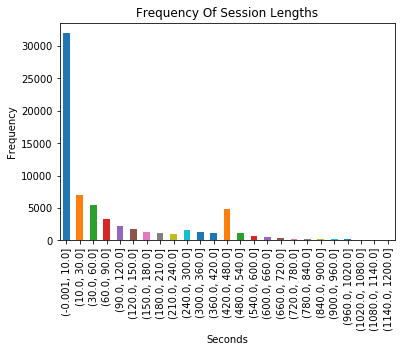

In [32]:
plt.figure(figsize=(6,4))
top_session_lengths.sort_index()\
                   .plot(kind='bar', 
                         title='Frequency Of Session Lengths')
    
plt.xlabel('Seconds')
plt.ylabel('Frequency')

We can see that most people spend either 10 seconds in a session. This means they probably are not finding what they want. Then the next largest groups of people spend 30 seconds, 7 minutes and 0 seconds respectively.  Let's see if there is a difference between the session length and session 'group'.

In [33]:
df3['session_length'] = temp_session_length
session_length_by_group = df3.groupby(['group_start'])['session_length']\
                             .value_counts(bins=bins)

<Figure size 432x288 with 0 Axes>

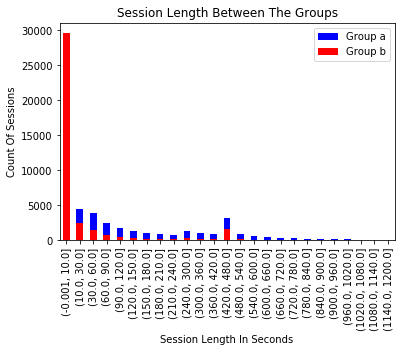

In [34]:
plot_session_length_by_group(session_length_by_group)

We can see that the magnitudes of numbers are very different between the two groups but the shape of the distributions are roughly the same.  Let's take a look at how the percentages change between the two groups, we can get this information from the series through,

In [35]:
session_length_a = session_length_by_group['a']
session_length_b = session_length_by_group['b']

tot_a = session_length_a.values.sum()
tot_b = session_length_b.values.sum()

session_length_a = session_length_a / tot_a
session_length_b = session_length_b / tot_b

And plot the results:

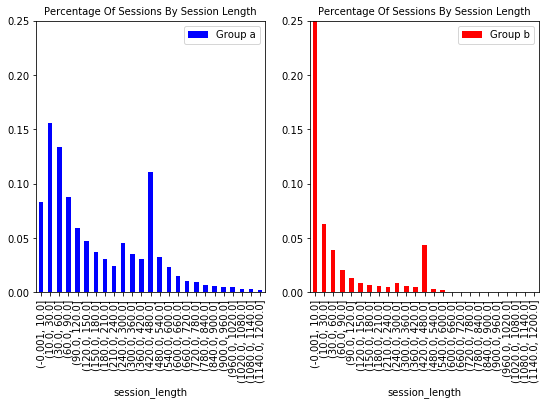

In [36]:
plot_session_length_by_group_percentages(session_length_a,
                                         session_length_b)

It seems like group b had a larger percentage of people with both almost 10 or less seconds
then group a.  Group b also seems like it had larger percentage of sessions that were 7 minutes than group a.  The 10 seconds or less is probably due to the higher zero rates in group b, but the 7 minutes I'm not able to explain right now.

Let's take a look at the number or results in each search. We'll look at the top 25, but we have to do this carefully since we cannot just count the number of rows that have <code>n_results</code> equal a number, since some people may actually change the search criteria within a session.  We therefore groupby <code>session_id</code> and take the unique number of listed search results. Since this returns a Pandas Series where the index is the <code>session_id</code> and the values are a list of <code>n_results</code> for each session I had to <a href="http://stackoverflow.com/questions/30885005/pandas-series-of-lists-to-one-series">chain</a> the values together before counting them:

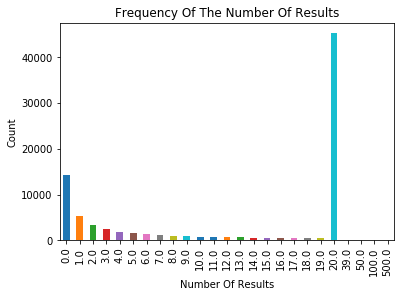

In [37]:
temp_results = df.groupby('session_id')['n_results'].unique()
temp_results = pd.Series(list(chain(*temp_results.values)))

number_of_results = temp_results.dropna()\
                                .value_counts()\
                                .head(25)
        
number_of_results.sort_index()\
                 .plot(kind='bar',
                       title='Frequency Of The Number Of Results')
    
plt.xlabel('Number Of Results')
plt.ylabel('Count')
plt.show()

It seems that most searches end up with 20 results and the two next highest are 0 and 1 results respectively. 

Let's take a look at the session lengths for number of <code>n_results</code> being 0, 1, 2, 3, 5, 10 and 20 and how this may be affected by value of <code>n_results</code>. We will take the number of <code>n_results</code> from the end of the session.  I wrote a function to find the disribution of percentages session length given the number of listed results <code>n_results</code> called <code>get_sessions_with_n_results</code>. The function takes in <code>df3</code> and the number of listed results and then returns a Pandas Series that is the distribution of percentages sessions with <code>session_length</code> and the value of listed of number of results <code>n_results</code>.

In [38]:
n_results = [0,1,2,5,10,20]
results = [get_sessions_with_n_results(df3, n) for n in n_results]

We plot the results below

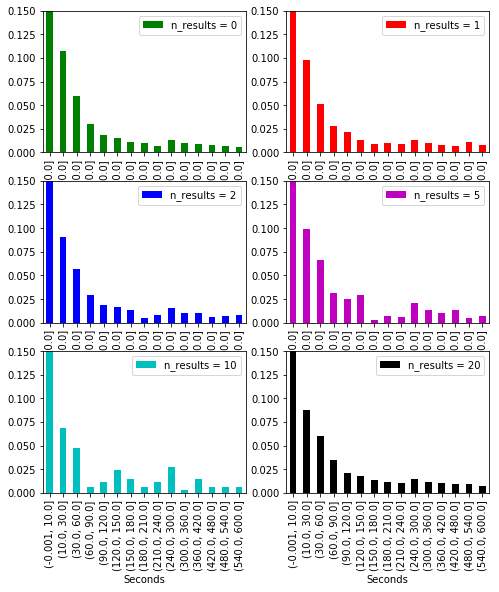

In [39]:
plt.figure(figsize=(8,12))
colors = ['g','r','b','m','c','k']
for i in range(1,len(n_results)+1):
    n = i-1
    plt.subplot(4,2,i)
    results[n].sort_index()\
              .plot(kind='bar', 
                    color=colors[n],
                    label='n_results = '+ str(n_results[n]))
        
    plt.legend()
    plt.xlabel('Seconds')
    plt.ylim([0, 0.15])

plt.show()

It doent look like there is much a difference between the number of results and how long people spend on the first clicked page.  Let's take the people who spent between 6 and 8 minutes on a link and take a look at which result page people clicked on:

In [40]:
title='result_position of page where people spent 6-8 minutes.'
df_420 = df3[df3.session_length < 480]
df_420 = df_420[df_420.session_length >= 360]
df_420.result_position_end.value_counts()
                          .plot(kind='bar',
                                title=title)
plt.xlabel('result_position')
plt.ylabel('Frequency')

IndentationError: unexpected indent (<ipython-input-40-7e0c18485574>, line 5)

It seems that the number people who spent 6-8 minutes on a resulting webpage were spending that time on the first listed result.  So one way to improve the clickthrough rate would be to focus on optimizing the listing engine such that first result is the very relevant. Focusing on getting many relevant searrch reults probably is not the best track since the number of results dont seem to effect how the session_length.

-------------------------------------------------------
## Conclusion <a class="anchor" id="seventh-bullet"></a>
-------------------------------------------------------

In this project we looked into factors that influence clickthrough rates on eight days of data from the Wikimedia foundation.  They had two different groups that users sessions were in, these are 'group a' and 'group b'.  We found that,

- 'group b' had a higher return of zero results and subsequently a lower clickthrough rate compared to 'group a'.


- Most of the search results either gave 20 or no search results.


- There wasnt much of a difference between how many listings there were and the session length.


- most of the sessions had time lengths that were either under 1 minute or between 6 and 8 minutes.  


- Most of the people clicked on the first listed result and the majority of people who had sessions lengths between 6 and 8 clicked ended their session on the webpage of the first listed result.



There are definitely more factors we could look into that could influence click through rate and session length, but that will have to wait for another day!